**AST4310, Autumn 2021, Julia version**

# Project 6a: 3D Line Formation
This project is based on work by Robert J. Rutten.

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});"""

In [2]:
using Unitful
using UnitfulRecipes   # To make unitful play with plots, otherwise need to ustrip(temp)
using Plots
import PhysicalConstants.CODATA2018: c_0, k_B, m_e, h, R_∞
import NumericalIntegration: integrate, cumul_integrate, TrapezoidalFast
import Polynomials: Polynomial
import DelimitedFiles: readdlm
using SpecialFunctions: erfcx
import FITSIO  # To read FITS files

# For shifting images:
using Images: warp, indices_spatial
using CoordinateTransformations, Interpolations

# Units and definitions
i_units = u"kW / m^2 / sr / nm"
@derived_dimension NumberDensity Unitful.𝐋^-3
@derived_dimension PerLength Unitful.𝐋^-1

## 1. Background

 <img src="https://i1.rgstatic.net/ii/profile.image/272391284719621-1441954551201_Q512/Robert_Stein.jpg" width="250px" alt="Bob Stein"> <img src="https://www.astro.ku.dk/~aake/aa03-med.jpg" style="width=250px; margin: -75px;" alt="Åke Nordlund">

*[Bob Stein](https://web.pa.msu.edu/people/steinr/research.html) (left, born 1935) and [Åke Nordlund](https://www.astro.ku.dk/~aake/)</a> (right, born 1947) are two pioneers of computer simulations of magneto-hydrodynamics (MHD). Their studies of plasma constrained by magnetic fields have had a deep impact in various fields, from planetary formation to the very finest scales in stellar surfaces. In particular, their prolific work on convection in the atmospheres of cool stars has led to a paradigm shift from seeing stellar atmospheres as static 1D plane-parallel objects to highly-dynamic 3D atmospheres. Their seminal work [Simulations of Solar Granulation](https://ui.adsabs.harvard.edu/abs/1998ApJ...499..914S) triggered a new age in the study of the solar and stellar atmospheres, where spectral calculations from 3D MHD simulations of convection became feasible and challenged our understanding of stellar spectra. Using such simulations, the solar metallicity,  stable during decades of modelling and observations, was suddenly challenged and revised by almost half by [Asplund et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005ASPC..336...25A). The codes developed by Nordlund and Stein have thrived and continued to be developed and updated at many research groups. They were at the origin of the Bifrost code, actively developed at our Institute and the source for the simulation in this Project. Photographs from the web.*

In Projects 4 and 5 you worked with the 1D FALC model, which is an empirical model (made to match observations) of the mean solar atmosphere, assuming that the solar atmosphere is horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent"). Of course, the solar atmosphere is neither homogeneous nor static. A more realistic description of a stellar atmosphere is given by time-dependent, radiative 3D magneto-hydrodynamic (MHD) simulations. They can capture more physics, such as a realistic treatment of convection and radiation at different depths, and don't need the fudge factors such as microturbulence to make the spectra look like the observations. 

A proper use of 3D models should include the temporal dimension, but for the sake of convenience and speedy calculations, we will use only a single timestep in this exercise. 


### 1.1 A 3D Model Atmosphere

The 3D simulation file is available in JupyterHub (see path below), but if you are using another computer you must [download it](https://www.uio.no/studier/emner/matnat/astro/AST4310/h20/data/qs006024_sap_s285.fits) (132 MB). This is one timestep of a simulation run with the [Bifrost code](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract), developed at [our Institute](https://www.mn.uio.no/astro/english/). This particular simulation is of quiet Sun (no strong magnetic fields), covers only a relatively small region (6 Mm x 6 Mm horizontal size), and does not include the hotter parts of transition region and corona (not relevant for this exercise). Here it is saved as a `QTable` in a special type of FITS file, so we can read it by:

In [3]:
"""
    read_qtable_fits(filename)

Reads a FITS file produced by astropy.QTable into a dictionary
"""
function read_qtable_fits(filename)
    fobj = FITSIO.FITS(filename)
    header = FITSIO.read_header(fobj[2])
    nvars = header["TFIELDS"]
    data = Dict()
    for i=1:nvars
        name = header["TTYPE$(i)"]
        unit = header["TUNIT$(i)"]
        # Convert unit to a format that Unitful understands
        unit = replace(unit, r" " => " * ")
        unit = replace(unit, r"\-" => "^-")
        data[Symbol(name)] = read(fobj[2], name) .* uparse(unit)
    end
    if haskey(header, "XPIX_KM") 
        data[:meta] = Dict(:xpix_km => header["XPIX_KM"] * u"km")
    end
    return data
end

read_qtable_fits

In [4]:
# Path only valid in JupyterHub at UiO:
DATA_FILE = "/src/data/AST4310/qs006024_sap_s285.fits"
atm3d = read_qtable_fits(DATA_FILE)

Dict{Any, Any} with 9 entries:
  :velocity_x       => Quantity{Float32, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(m, s⁻¹), 𝐋 𝐓…
  :temperature      => Quantity{Float32, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}…
  :velocity_z       => Quantity{Float32, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(m, s⁻¹), 𝐋 𝐓…
  :pressure         => Quantity{Float32, 𝐌 𝐋⁻¹ 𝐓⁻², Unitful.FreeUnits{(Pa,), 𝐌 …
  :height           => Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}…
  :meta             => Dict{Symbol, Quantity{Float64, 𝐋, Unitful.FreeUnits{(km,…
  :electron_density => Quantity{Float32, 𝐋⁻³, Unitful.FreeUnits{(m⁻³,), 𝐋⁻³, no…
  :hydrogen_density => Quantity{Float32, 𝐋⁻³, Unitful.FreeUnits{(m⁻³,), 𝐋⁻³, no…
  :velocity_y       => Quantity{Float32, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(m, s⁻¹), 𝐋 𝐓…

The file structure was built so that it looks very similar to the loaded FALC model. Many of the variable names have the same names (e.g. `temperature`, `electron_density`), but not all the quantities present in the FALC model are here. `vturb` is absent, but instead we have `velocity_z`, `velocity_y`, and `velocity_x`, respectively the velocity components in the z, y, and x axes. You will also notice that each variable is now a 3D array, e.g.:

In [5]:
size(atm3d[:temperature])

(256, 256, 75)

The array dimensions are (nx = 256, ny = 256, nz = 75). We can compare some quantities between the FALC and one column of the 3D model:

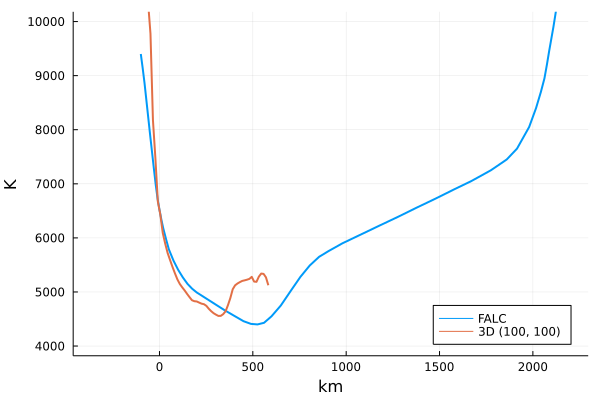

In [6]:
"""
Reads a table in a text file, formatted with column names in first row,
and unit names on second row. Any deviation from this format will fail.
"""
function read_table_units(filename)
    data = readdlm(filename, comments=true)
    tmp = readdlm(filename, comments=false)[1:2, 2:end]
    qnames = Tuple(Symbol(name) for name in tmp[1, :])
    units = tmp[2, :]
    (; zip(qnames, Tuple(data[:, i] * uparse(units[i]) for i in eachindex(data[1, :])))...)
end

falc = read_table_units("falc.dat")

plot(falc[:height] .|> u"km", falc[:temperature], label="FALC", w=2)
# Show column (100, 100):
plot!(atm3d[:height] .|> u"km", atm3d[:temperature][100, 100, :], 
      label="3D (100, 100)", ylim=[4000, 10000], w=2, legend=:bottomright)

We can also visualise the horizontal maps of variables at a given height using the `heatmap` function from Plots.jl. Here for the temperature at the bottom of the atmosphere (last height point):

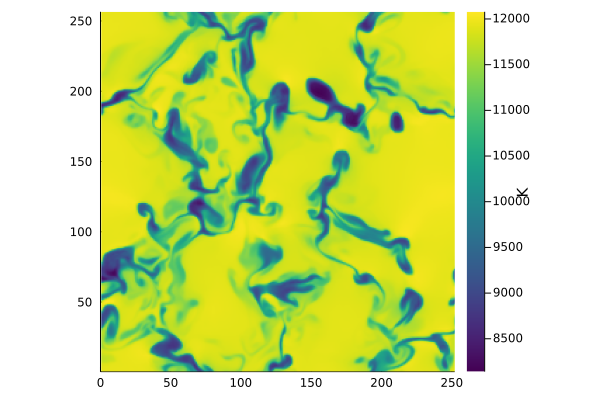

In [7]:
heatmap(atm3d[:temperature][:, :, end], seriescolor=:viridis, 
        aspect_ratio=:equal, xlim=[0, 252])

### 1.2 Radiative Transfer in 3D

We saw earlier that for a 1D plane-parallel atmosphere, the intensity for a direction defined by $\mu$ is given as:


\begin{equation}
    \label{eq:ilambda}
    I_\lambda(\mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
\end{equation}

How does this work in 3D? Lets first consider the case of $\mu=1$. We don't have a plane-parallel semi-infinite atmosphere, but a 3D box with limited horizontal extent. This can also be seen as a set of 1D columns, where each vertical column in the box behaves like a mini-atmosphere. So for $\mu=1$ we can still use equation (\ref{eq:ilambda}), solving for each 1D column in the box as it was a plane-parallel atmosphere. A simplistic view of this integration along the height scale will look like this for $\mu=$1:

<img src="https://tiagopereira.space/ast4310/images/ray_straight.svg" height=300px>

Now $S_\lambda$ and $\tau_\lambda$ will be 3D arrays, and for each wavelength the resulting $I_\lambda$ will be a 2D map (we integrated in the vertical direction).

But how to calculate  $I_\lambda(\mu)$ for $\mu\neq 1$? In this case, we cannot simply treat each column in the box as a plane-parallel atmosphere, because inclined rays are going across the box and therefore cross many of those "columns":

<img src="https://tiagopereira.space/ast4310/images/ray_inclined.svg" height=300px>


There are two ways to solve the radiation along inclined rays. One way is to calculate the simulation quantities (temperature, electron density, etc.) along the inclined rays, which needs many interpolations and figuring out which cell the ray intersects at which point. A much easier way is instead of tilting the rays, to tilt the simulation box instead, and use the same functions to integrate along the vertical direction. Such as this diagram:

<img src="https://tiagopereira.space/ast4310/images/box_inclined.svg" height=300px>

One thing we need to sort out is how to deal with the missing "blocks". See the arrow on right side: it must go through some volume, but what values to use there? Here we use a nice property of these simulations: they are horizontally periodic. This means that if we shift one layer of the simulation horizontally, what comes in in the missing right side is what went out of the domain on the left side. 

Such "shifting" of a layer (2D array) can be achieved in Julia using the `shift_image()` function below, using tools from Images.jl and CoordinateTransformations.jl:

In [8]:
"""
    shift_image(image::Array, shift_x::Real, shift_y::Real)

Shift a 2D array by an amount of `shift_x` and `shift_y` pixels,
in the first and seecond dimensions. Assumes the image is horizontally
periodic, so the returned array has the same dimensions as `image`.
"""
function shift_image(image::Array, shift_x::Real, shift_y::Real)
    transl = Translation(shift_x, shift_y)
    warp(image, transl, indices_spatial(image), Linear(), Periodic())
end

shift_image

To get a "shifted" version of the simulation box for a given ray, you'll need to do this shifting for all layers, and then redefine the height scale because the rays will go through a distance of $z / \mu$. You can then integrate as before, assuming each column of the new 3D box to be a plane-parallel 1D atmosphere. The final $I_\lambda(\mu)$, for a given $\lambda$ will also be a 2D array of (nx, ny), but its aspect ratio will be changed depending on the angle (ie, the rays will be more densely packed).

**Important:** when you do the above "shifting" of a 3D cube, you will need to know the physical size of each pixel (in the horizontal direction). This is saved in a special variable in the `atm3d` object:

In [9]:
atm3d[:meta][:xpix_km]

23.4375 km

### 1.3 Spectral Lines in 3D

#### 1.3.1 Velocities

The 3D model does not contain an array with the turbulent velocity (microturbulence). Instead, you have three quantities named `velocity_z`, `velocity_x`, and `velocity_y`. These will change the line-of-sight velocity $v_\mathrm{los}$ and cause a Doppler shift. But how do these shifts relate to the Doppler broadening? The Doppler effect can be written as:


$$
\frac{\Delta\lambda}{\lambda_0} = \frac{v}{c}
$$

In the case of thermal broadening, 
$$
v = v_\mathrm{th} = \sqrt{\frac{2 k_B T}{m}},
$$

and

$$
\Delta\lambda \equiv \Delta\lambda_D = \frac{\lambda_0}{c}\sqrt{\frac{2 k_B T}{m}}.
$$

In other cases, a given velocity $v_\mathrm{los}$ along the line of sight will cause a line shift $\Delta\lambda$ according to the first expression. In 1D plane-parallel radiative transfer, velocity variations along the line of sight are "accounted for" by using a microturbulence $v_\mathrm{turb}$, a term that is added inside $\Delta\lambda_D$ as:

$$
\Delta\lambda_D = \frac{\lambda_0}{c}\sqrt{\frac{2 k_B T}{m} + v_\mathrm{turb}^2}.
$$

In 3D radiative transfer, turbulent motions from the simulations exist naturally, so $v_\mathrm{turb}$ is unnecessary. Instead, at each point in the 3D simulation the line profile has the usual Voigt profile shape $V(a, v)$ but it is shifted by $\Delta\lambda$, which is a function of $v_\mathrm{los}$ for each point in the grid, and each direction. But how do we enter this shift in the Voigt profile?

The way the Voigt function is built, it is a function of the damping parameter $a$ and the wavelength shift divided by the thermal broadening $\Delta\lambda_D$, let's call it $v_\mathrm{norm}$:

$$
v_\mathrm{norm} \equiv \frac{\Delta\lambda_i}{\Delta\lambda_D},
$$

where $\Delta\lambda_i$ is an array of wavelength shifts around the line centre $\lambda_0$, e.g. $\Delta\lambda_i = -0.2, -0.1, 0, 0.1, 0.2$ nm. This is a way to measure the wavelength spacing in units of thermal broadening. So for $v_\mathrm{norm}=$ 1 we are one Doppler broadening away from the line core, $v_\mathrm{norm}=$ 5, five Doppler broadenings and so on. In this example we use $-$10 $< v_\mathrm{norm} <$ 10, which covers most of the line. By definition, the peak of the Voigt function will be at $v_\mathrm{norm}=$ 0. However, when there is a Doppler shift $\Delta\lambda_\mathrm{los}$ caused by a line-of-sight velocity:

$$
\Delta\lambda_\mathrm{los} = \lambda_0\frac{v_\mathrm{los}}{c},
$$

the peak of the Voigt function should be at $v_\mathrm{norm}=-\Delta\lambda_\mathrm{los} / \Delta\lambda_D$. In this definition, a positive $v_\mathrm{los}$ corresponds to an upflow (movement towards the observer), meaning that the wavelength shift is negative (blueshift). The way to add this shift $\Delta\lambda_\mathrm{los}$ is *not* in the Doppler width, but in $v_\mathrm{norm}$, and at every grid point of the simulation, because the line of sight will be different at every grid point. In the 3D case, the calculation of the normalised velocity $v_\mathrm{norm}$ (for the Voigt function) should therefore be:

$$
v_\mathrm{norm} = \frac{\left(\Delta\lambda_i + \Delta\lambda_\mathrm{los} \right)}{\Delta\lambda_D}.
$$

When $\mu=1$, $v_\mathrm{los} = v_z$. For $\mu\neq 1$, you will need to project the velocities, so that

$$
v_\mathrm{los} = v_z \cos\theta + v_y \sin\theta \sin\varphi + v_x \sin\theta \cos\varphi,
$$

where $\theta$ is the polar angle ($\mu=\cos\theta$) and $\varphi$ the azimuthal angle.

For rotations around the azimuthal angle, it is best to use only the multiples of 90° (0°, 90°, 180°, 270°). This way, all the 3D cubes can be kept in the same way in memory through transposition or array manipulation, and avoid time-consuming interpolations. (Just be sure to reorder $v_x$ and $v_y$ accordingly.)


#### 1.3.2 Computational efficiency and limiting memory use

If the same approach to calculate spectral lines for the 1D case is followed in the 3D case, arrays such as the line profile and several others can become 4D arrays: `(nx, ny, nz, nwave)`. With the shape of the 3D model provided, using 200 wavelength points and storing as double precision, _each_ array will take up 7.32 GB of RAM. Unless you have a lot of RAM to waste, you will need to develop a strategy to avoid storing so much data in memory. The most natural way to do this is to save only 3D arrays of space, and have a loop running over wavelength. You can also use fewer wavelength points, assuming you cover the line reasonably. This problem is, in fact, perfectly parallel in the wavelength dimension.

You will also notice that all simulation variables are saved as single-precision (32-bit floats). This was intentional, as using double-precision will mean using twice as much memory. In some cases, particularly in the Saha calculation, intermediate results need to be done in double precision, otherwise a floating overflow will occur and the result will be NaN. Be on the lookout for overflow warnings if you find some unexpected result.


---

### Exercise 1: Continuous Height of Formation in 3D [28 points]


In this exercise, you will perform calculations similar to those you did in Project 5, exercise 1. Instead of solving for the FALC model, you will use the 3D model. Do all calculations for $\mu=1$.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Write (or reuse code) to compute $\tau_{500}$, the continuum optical depth at 500 nm (using extinction from H$^-$ and Thomson scattering) for the 3D model. This should be a 3D array. There is no `proton_density` available for the 3D model, so just use `hydrogen_density` in `compute_hminus_cross_section`. Each column in the 3D model is like a different 1D atmosphere, so each column has a different $\tau_{500}$. There are 256x256 columns in the 3D model, so it makes little sense to plot them all. Choose a small number of columns and plot $\tau_{500}$ as function of height (all in one figure), along with the $\tau_{500}$ you computed from the FALC model. Discuss the differences and the range of the variations.
    
* In the 3D case $h(\tau_{500}=1)$, the height where $\tau_{500} = 1$ (when the atmosphere becomes transparent for 500 nm), varies along the horizontal dimensions. Using your already calculated $\tau_{500}$, calculate and plot $h(\tau_{500}=1)$ by interpolating, for each column, the curve of $\tau_{500}$ vs height. Show $h(\tau_{500}=1)$ as a 2D plot (image) and as a 3D surface plot (see below for hints on how to make this plot). Which column is formed deeper, and which one is formed higher up in the atmosphere?

* Discuss the spatial variations of the $h(\tau_{500}=1)$ you found. Do these relate to spatial structures in the simulation? Which quantity/quantities from the simulation better reflect the map of $h(\tau_{500}=1)$? (Hint: have a look at vertical cuts from the simulation quantities.)
    
* The height scale of the simulation is built such that $h=0$ m when $\tau_{500}=1$. Is the average value of your $h(\tau_{500}=1)$ close to zero? Discuss possible effects that may lead to a mismatch.
    
</div>


A 3D surface plot of $h(\tau_{500}=1)$ can be created with this code:

```julia
x = LinRange(0, 6, 256)u"Mm"
plot(x, x, tau1_height .|> u"km", st=:surface, c=:magma, camera=(40, 50), 
     xlabel="x", ylabel="y", zlabel="z", background_color_subplot=:gray95)
```

This should give a plot similar to the following:

<img src="https://tiagopereira.space/ast4310/images/tau1_3d_julia.png" width=500px>


### Exercise 2: Continuous Intensity at Different Angles [27 points]

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Using $\tau_{500}$ you computed in the previous exercise, now compute and plot the disk-centre continuous intensity at 500 nm from the 3D model. The result should look like the solar granulation.
  
* Compute the continuous intensity at 500 nm from the simulation at two viewing angles: $\mu$=0.4 and 0.2 (inclination angles of about 66° and 78°). Plot both intensity maps with identical physical sizes in the x and y axes.
    
* In 3D space a rotation can be along two angles. Here, $\mu$ represents a rotation along the polar angle, but one can also do a rotation around an azimuthal angle. How would you rotate the simulation cubes by an azimuthal angle? You don't need to actually rotate the cubes, just explain how you would do it. (Think multiples of 90° rotations, and it becomes much easier.)


*Hints:* for $\mu \neq 1$ you can use the same code as for $\mu=1$, just "shift" the simulation box as described above. By tilting the simulation you will obtain intensity maps that have the same number of pixels (256 x 256), but the rotation compresses the physical size by $\mu$ along the direction that was tilted. You will need to account for that in your plotting. Your result should look like the image below:  
</div>

<img src="https://tiagopereira.space/ast4310/images/Inclined_Icont_julia.svg" height=300px>


### Exercise 3: The Na I D lines in 3D [40 points]

Now you will recreate part of Project 5 but in 3D. Using the same strategy as in Exercise 2, write (or reuse) code to compute the intensity for the Na I D$_1$ line for the 3D model.


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu = 1$. You will need to modify the code you used in Project 5, both to add physics and to avoid filling up the memory of your computer (see hints in 1.3.2). Compute the spatially-averaged line profile, and plot it against a selection of line profiles from different xy points of the simulation (e.g. every 10th point in the y and x directions), so you can see the spatial variations between line profiles).
    
* After you compute the intensities in the point above, you should obtain an array whose shape is `(nx, ny, nwave)`. Plot a spectrogram along one row or column of the simulation (e.g. `intensity_3d[:, :, 1]`), where the x axis is wavelength and the y axis is physical distance in Mm. You should see the meandering shifts of the line core, caused by Doppler motions. Exploring spectrograms from different slices, try to find a simulation column for which the line core peak is stronger (or comparable) than the intensity in the far wings. Compare with a different location where the wings are much stronger than the line core. Plot the two spectra and, based on your radiative transfer knowledge, explain the reason why they look so different. (Hint: look at the two source functions.)

* For stars other than the Sun, we can only observe $F^+_\lambda$, the spatially-averaged flux profile, not the intensity at different angles and positions. Compute and plot the spatially-averaged Na I D$_1$ flux profile from the 3D model. You will need to calculate intensities for several angles and add them together using the flux integration techniques discussed in Project 5. Use 3 polar angles (same as in Project 5) and 4 azimuthal angles. To compute the intensity in 3D for inclined rays, the procedure is mostly identical to the $\mu=1$ case, but in addition to tilting the simulation's cubes, you will have to project the $v_x$, $v_y$, and $v_z$ components of velocity to obtain the line-of-sight velocity. **Note:**  *this computation will probably take more than one hour in modern machines. Make sure you have done everything correctly to this point to avoid long re-runs.*
</div>